## **Consensus Trees Annotated with Category and Abundance**
__Introduction__
In this notebook, we aim to visualize the consensus phylogenetic trees generated in the previous notebook 4_sequences_find.ipynb. The primary focus is to annotate these trees based on two key parameters:

Category: depending on the failure analysis category 1,2,3.
Abundance: The percentage of abundance of the genus on a sample, normalised to the sample.
By doing so, we seek to gain insights into the microbial community relationships and posterior metabolism pathways and its potential role in the system's failure.

__Objective__
Identify the genus that are associated with the failure analyis on a positive or inverse way.
__Methodology__
We use the ETE Toolkit for the visualization, employing various annotations and styles to represent the category and abundance data. The tree is scaled and styled to facilitate easy interpretation.

In [2]:
'''%pip install dendropy
%pip install --upgrade pip'''

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing the libraries 
import os
import pandas as pd
import dendropy 
from dendropy import Tree
import matplotlib.pyplot as plt
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace, faces # anotate the tree with abundance agregated data
import tempfile
from Bio import Phylo
from IPython.display import display, Image # Display image inline


Now I have a dataframe with information of category and abundance for the genera found on the distintic sites/samples
I want to anotate the tree with that info.

In [2]:
select = pd.read_excel('data/selected_to_note.xlsx')
#droping the first column 
select = select.iloc[:, 1:]
#separating the category 
category_dict = select.iloc[0, 7:].to_dict()

In [3]:
# Create a new df just for genus and jointax
jointax_df = select[["Genus", "Jointax"]].iloc[1:].reset_index(drop=True)

In [4]:
# Create a dictionary mapping "Genus" to "Jointax"
jointax_dict = jointax_df.set_index("Genus")["Jointax"].to_dict()

In [23]:
# Loading the tree
t = Tree("data/consensus_tree.newick", format=1)
# Traverse the tree and rename nodes from Genus to Jointax
for leaf in t.iter_leaves():
    if leaf.name in jointax_dict:
        leaf.name = jointax_dict[leaf.name]


The number of observation per genus is relatively large (70) to be observed on a tree, therefore it is pertinent to make an agregation to the data so that it is possible to visualise the impact of each genus per abundance and category.

In [24]:
# Initialize an empty dictionary to store the aggregated data
aggregated_data = {}

# Loop through each row in the DataFrame
for index, row in select.iterrows():
    genus = row['Genus']
    if genus not in aggregated_data:
        aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}
    
    # Loop through each site column
    for site_column in select.columns[7:]:
        category = category_dict[site_column]
        abundance = row[site_column]
        
        # Aggregate the abundance data by category
        if category == 1:
            aggregated_data[genus]['category_1'] += abundance
        elif category == 2:
            aggregated_data[genus]['category_2'] += abundance
        elif category == 3:
            aggregated_data[genus]['category_3'] += abundance
            
# Colors for each category
category_colors = {'category_1': 'green', 'category_2': 'orange', 'category_3': 'red'}

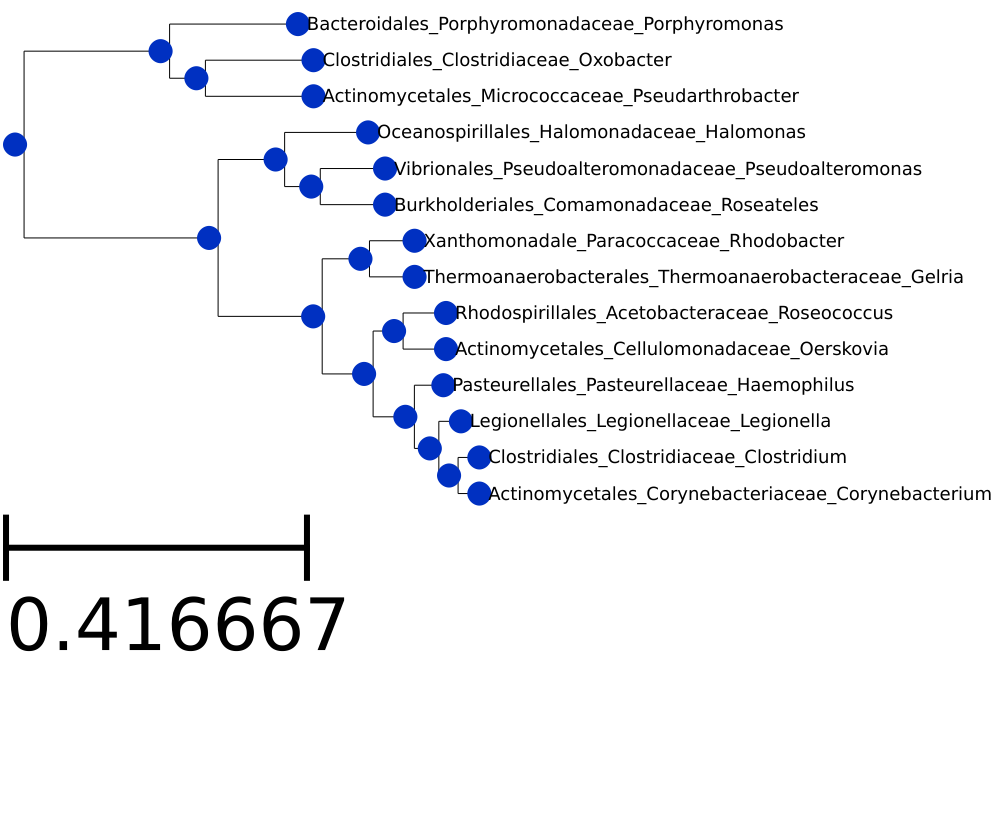

In [25]:
# Annotate the tree with aggregated abundance data
for node in t.traverse():
    if node.name in aggregated_data:
        for category, abundance in aggregated_data[node.name].items():
            color = category_colors[category]
            bar = RectFace(width=abundance, height=3, fgcolor=color, bgcolor=color)
            node.add_face(bar, column=1, position="branch-right")
            
#Loop through each leaf node to add a TextFace with the desired font size
for leaf in t.iter_leaves():
    name_face = TextFace(leaf.name, fsize=2)  # Set the font size to 10
    leaf.add_face(name_face, column=0, position="branch-right")
   
# Basic tree style
ts = TreeStyle()
ts.show_leaf_name =False
ts.branch_vertical_margin = 2  # 10 pixels between adjacent branches
ts.scale = 120  # Default is 120, increase to make the tree wider

# Render and display the tree
t.render("%%inline", w=1000, units="px", tree_style=ts)

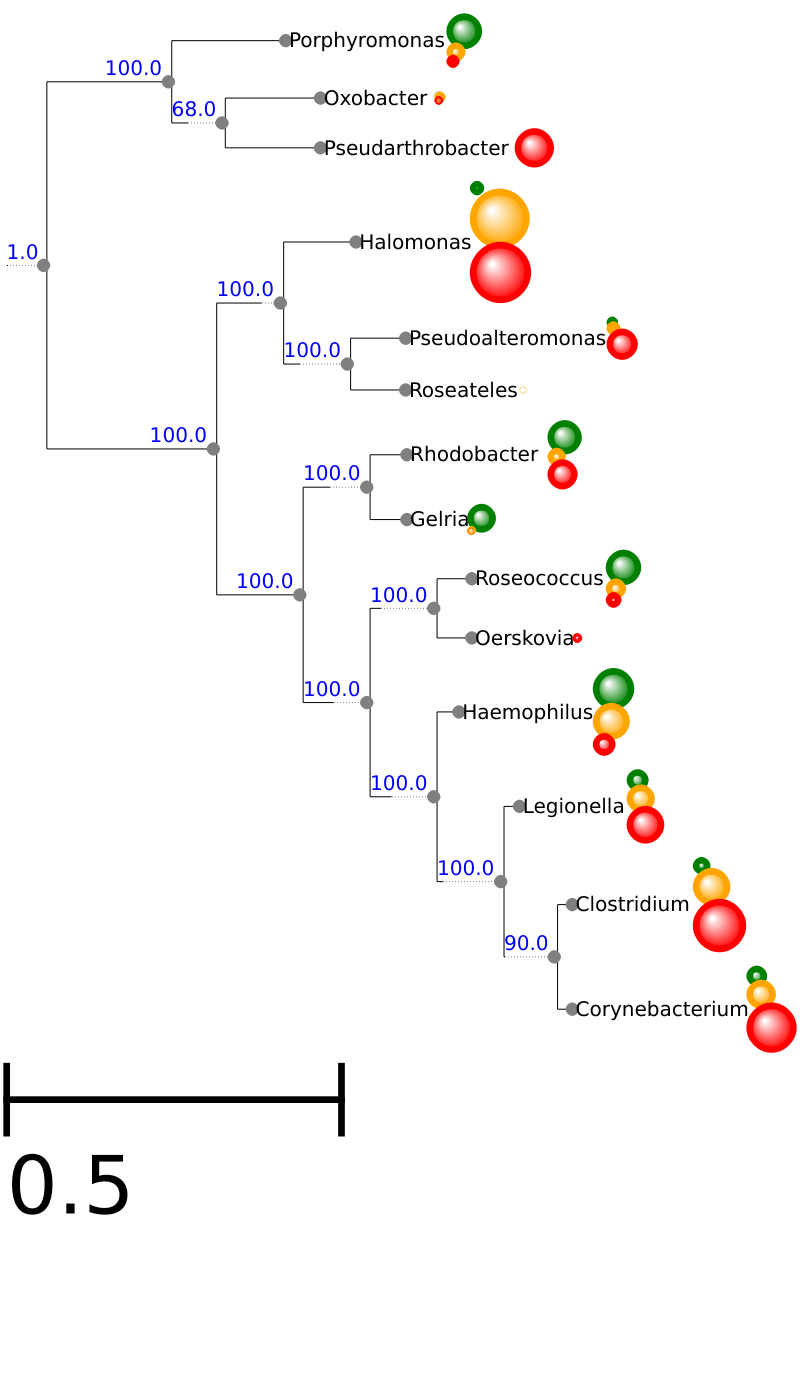

In [18]:
from ete3 import Tree, TextFace, NodeStyle, faces, TreeStyle, CircleFace
from math import log


# Load the tree
t = Tree("data/consensus_tree.newick", format=0) 

#Loop through each leaf node to add a TextFace with the desired font size
for leaf in t.iter_leaves():
    name_face = TextFace(leaf.name, fsize=2)  # Set the font size to 10
    leaf.add_face(name_face, column=0, position="branch-right")

# Create a TreeStyle object
ts = TreeStyle()
ts.show_leaf_name = False
ts.branch_vertical_margin = 3
ts.scale = 100

# Create a NodeStyle object
nstyle = NodeStyle()
nstyle["shape"] = "circle"
nstyle["size"] = 1
nstyle["fgcolor"] = "grey"

# Apply the node style to all nodes
for n in t.traverse():
    n.set_style(nstyle)

# Annotate the tree
for node in t.traverse():
    if node.name in aggregated_data:
        for category, value in aggregated_data[node.name].items():
            color = category_colors[category]
            scaled_radius = log(value + 1)
            circle = CircleFace(radius=scaled_radius, color=color, style="sphere")
            node.add_face(circle, column=1, position="branch-right")

# Add bootstrap values
def my_layout(node):
    if not node.is_leaf():
        bootstrap_label = TextFace(str(node.support), fsize=2, fgcolor="blue")  # Adjust fsize here
        faces.add_face_to_node(bootstrap_label, node, column=0, position="branch-top")

ts.layout_fn = my_layout

# Render the tree
t.render("%%inline", w=800, units="px", tree_style=ts)

### Results and Discussion
The annotated phylogenetic tree allows us to make several key observations:

Relevance of Genera: The tree highlights 15 genera as the most relevant in this study, those were found on previous notebooks and correspond to the genera that show a statistically significant varianz on abundance in operational heat and coolign systems, and have been clasified on three categories of failure: 
* 1-Green-->  systems with no failure  
* 2-Orange--> sistems starting to show failure  
* 3-Red -->   systems with detected failure  
Some systems present on all category and the abundance increase with increasing the failure, such are 
Protective Factors: Some genera are present across all categories but show an inverse relationship with system failure, suggesting a possible protective role.
Conclusion
While correlation does not imply causation, the statistical analysis and filtering of bacteria enable us to focus on specific genera for more comprehensive studies involving physicochemical factors. This could help us understand their influence on the system's failure or success. Additionally, some branches of the tree are exclusively associated with failed systems, warranting a more detailed metabolic study.